# Test on using parallel processing in python

http://davidmasad.com/blog/simulation-with-ipyparallel/

## Connecting to your cluster

In [1]:
import ipyparallel

> Next, connect to the engines, and make sure there are four of them (or however many you decided to launch):

In [2]:
clients = ipyparallel.Client()
clients.ids

[0, 1, 2, 3, 4, 5, 6, 7]

> Next, we need to create a **direct view** into the engines, which will give us direct control over them. (There is also a **load balanced view** which seems both less documented and less suitable for what we're doing here). We can do this two ways:

In [3]:
dview = clients[:]

# or dview = clients.direct_view()

> To test that everything is working, you can define a trivial function and distribute it to the engines:

In [4]:
def square(x):
    return x**2
 
results = dview.map_sync(square, range(4))
print(results)

[0, 1, 4, 9]


> You can give more arguments than there are engines, and the system will automatically divide them among the engines. The sync in map_sync means that it will wait until all the results are back before continuing to run.

> If you want to use a function which takes more than one argument, you provide the sequences of arguments one after the other, e.g.:


In [5]:
def multi(a, b):
    return a*b
 
results = dview.map_sync(multi, [0, 1, 3, 5], [2, 4, 6, 8])
print(results)

[0, 4, 18, 40]


# Simulating π

One classic simple example of doing science (or math) via numeric simulation is the Monte Carlo estimation of $\pi$. You may remember from high school math that the ratio between the areas of a square with side-length 1 and a circle with diameter 1 is π4≈0.785π4≈0.785.

Suppose we pick random points in a square with a circle drawn in the middle, and looked at the fraction of dots that landed inside the circle. As the number of random points grows larger, the fraction of dots inside the circle should get closer and closer to π4π4. To make things even easier, we can only look at one quarter of the square-and-circle.

In [6]:
%%time
import random
 
def mc_pi(n):
    count = 0
    for i in range(n):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) <= 1:
            count += 1
    return count/n

est_pi = mc_pi(10**6)
print(est_pi)

0.78578
CPU times: user 428 ms, sys: 0 ns, total: 428 ms
Wall time: 428 ms


This is another embarrassingly parallel task, since none of the random draws depend on one another. We can speed it up by having each core randomize 250,000 points, and aggregate the results together.

The intuitive thing to do now would be to just map_sync the function across all the engines:

results = dview.map_sync(mc_pi, [250000]*4)

**But if you tried that, you'd get an error -- four errors actually, one for each engine. As I understand it, the engines are (more or less) miniature Python sessions running independently. Just because you imported something -- in this case, random -- into the Hub session doesn't mean it was imported into all of the separate engines. We have to do that explicitly:**

In [7]:
%%time
with dview.sync_imports():
    import random
est_pis = dview.map_sync(mc_pi, [500000]*2)
print(sum(est_pis)/2)  

importing random on engine(s)
0.7850170000000001
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 393 ms


In [8]:
%%time
with dview.sync_imports():
    import random
est_pis = dview.map_sync(mc_pi, [250000]*4)
print(sum(est_pis)/4)

importing random on engine(s)
0.785712
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 240 ms


In [9]:
%%time
with dview.sync_imports():
    import random
est_pis = dview.map_sync(mc_pi, [125000]*8)
print(sum(est_pis)/8)    

importing random on engine(s)
0.7847280000000001
CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 148 ms


In [10]:
%%time
with dview.sync_imports():
    import random
est_pis = dview.map_sync(mc_pi, [100000]*10)
print(sum(est_pis)/10)    

importing random on engine(s)
0.78568
CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 171 ms


In [20]:
(10**6)/8

125000.0

# Parallel Model

In [29]:
from mesa import Agent, Model
from mesa.time import RandomActivation

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()


In [45]:
model = MoneyModel(500)
for i in range(500):
    model.step()

(array([ 232.,  137.,   73.,   33.,    0.,   15.,    4.,    5.,    0.,    1.]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ]),
 <a list of 10 Patch objects>)

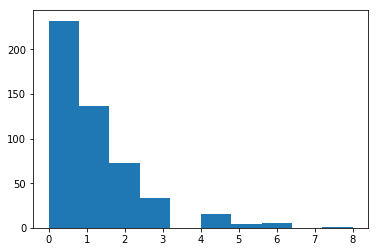

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

> Despite that on average, every agent should give and get one unit of money each step, we see that most agents end up with no money, and an increasingly small number end up with more and more of it.

> Of course, this is just one random run with some particular parameters, and there's no way for us to tell whether these results are typical or not1 So we need to run the model multiple times. Who could have guessed this is where this was going?

> To do this serially on a single core, we can do something like this:

In [48]:
all_models = []
for i in range(10):
    model = MoneyModel(500)
    for i in range(500):
        model.step()
        all_models.append(model)

In [54]:
with dview.sync_imports():
    import random
    from mesa import Model, Agent
    from mesa.time import RandomActivation
    
dview.push({"MoneyAgent": MoneyAgent, "MoneyModel": MoneyModel})    


def make_model(_):
    model = MoneyModel(500)
    for i in range(500):
        model.step()
        all_models.append(model)
        
all_models = dview.map_sync(make_model, [None]*10)

importing random on engine(s)
importing Model,Agent from mesa on engine(s)
importing RandomActivation from mesa.time on engine(s)


RecursionError: maximum recursion depth exceeded